# Sanity check confounding variable

Objective: make sure that the correlations we are seeing isn't due to some big fluke with the ordering of the cell numbers

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell
import seaborn as sns

In [2]:
assert os.path.basename(os.getcwd()) == 'project-formation'

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Helvetica'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8),
                    'facecolor'  : 'white'
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')



DPI = 600
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Load resources

In [4]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Get the summary statistics for each cell

In [5]:
all_summary_data = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    print(f'Compiling data on cell #{cell.cellid}...')
    
    curr_summary = dict()

    curr_summary['cellid'] = cell.cellid
    curr_summary['channel_number'] = cell.get_channel_number()
    curr_summary['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    curr_summary['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    
    # Add information from the formation cycles
    curr_summary.update(cell.get_formation_test_summary_statistics())
    curr_summary['form_coulombic_efficiency'] = curr_summary['form_final_discharge_capacity_ah'] / curr_summary['form_first_charge_capacity_ah']
    
    # Add the results from the aging test
    curr_summary.update(cell.get_aging_test_summary_statistics())
    
    # Add the eSOH fitting results for two different cycle numbers
    df_esoh = cell.get_esoh_fitting_results()
    df_esoh_c3 = df_esoh[df_esoh['cycle_number'] == 3].drop(columns=['cellid', 'cycle_number'])
    df_esoh_c56 = df_esoh[df_esoh['cycle_number'] == 56].drop(columns=['cellid', 'cycle_number'])
    curr_summary.update(df_esoh_c3.add_prefix('esoh_c3_').to_dict('records')[0])
    curr_summary.update(df_esoh_c56.add_prefix('esoh_c56_').to_dict('records')[0])
                                                
    curr_summary['is_plating'] = 1 if cell.is_plating() else 0
    curr_summary['swelling_severity'] = cell.get_swelling_severity()
    curr_summary['thickness_mm'] = cell.get_thickness()
    curr_summary['electrolyte_weight_g'] = cell.get_electrolyte_weight()
    
    all_summary_data.append(curr_summary)
    
df_corr = pd.DataFrame(all_summary_data)

Compiling data on cell #1...
Compiling data on cell #2...
Compiling data on cell #3...
Compiling data on cell #4...
Compiling data on cell #5...
Compiling data on cell #6...
Compiling data on cell #7...
Compiling data on cell #8...
Compiling data on cell #10...
Compiling data on cell #11...
Compiling data on cell #12...
Compiling data on cell #13...
Compiling data on cell #14...
Compiling data on cell #15...
Compiling data on cell #16...
Compiling data on cell #17...
Compiling data on cell #18...
Compiling data on cell #19...
Compiling data on cell #20...
Compiling data on cell #21...
Compiling data on cell #22...
Compiling data on cell #23...
Compiling data on cell #24...
Compiling data on cell #25...
Compiling data on cell #26...
Compiling data on cell #27...
Compiling data on cell #28...
Compiling data on cell #29...
Compiling data on cell #30...
Compiling data on cell #31...
Compiling data on cell #32...
Compiling data on cell #33...
Compiling data on cell #34...
Compiling data on 

In [6]:
df_corr.columns.values

array(['cellid', 'channel_number', 'is_room_temp_aging',
       'is_baseline_formation',
       'form_first_discharge_capacity_below_3p2v_ah',
       'form_first_discharge_rest_voltage_rebound_1s',
       'form_first_discharge_rest_voltage_rebound_10s',
       'form_first_discharge_rest_voltage_rebound_1800s',
       'form_last_charge_voltage_trace_cap_ah',
       'form_last_charge_voltage_trace_voltage_v',
       'form_last_charge_voltage_after_1s',
       'form_last_charge_voltage_after_10s',
       'form_last_charge_voltage_after_60s',
       'form_first_charge_capacity_ah',
       'form_first_discharge_capacity_ah', 'form_first_cycle_efficiency',
       'form_final_discharge_capacity_ah',
       'form_6hr_rest_delta_voltage_v_0_to_1_hr',
       'form_6hr_rest_delta_voltage_v_0_to_2_hr',
       'form_6hr_rest_delta_voltage_v_0_to_3_hr',
       'form_6hr_rest_delta_voltage_v_0_to_4_hr',
       'form_6hr_rest_delta_voltage_v_0_to_5_hr',
       'form_6hr_rest_delta_voltage_v_0_to_6_hr'

In [7]:
df_corr

,cellid,channel_number,is_room_temp_aging,is_baseline_formation,form_first_discharge_capacity_below_3p2v_ah,form_first_discharge_rest_voltage_rebound_1s,form_first_discharge_rest_voltage_rebound_10s,form_first_discharge_rest_voltage_rebound_1800s,form_last_charge_voltage_trace_cap_ah,form_last_charge_voltage_trace_voltage_v,...,c20_dch_cap_at_c630_ah,c20_minus_c3_dch_cap_at_c630_ah,c20_over_c3_dch_cap_at_c630_ah,var_q_c20_c574_c3_ah,var_q_c20_c574_c3_delta_q,var_q_c20_c574_c3_voltage_v,c3_dch_cap_at_c573_ah,c20_dch_cap_at_c574_ah,c20_minus_c3_dch_cap_at_c574_ah,c20_over_c3_dch_cap_at_c574_ah
0,1,22.0,0,1,0.077820,3.010586,3.057576,3.382315,1559 2.185772 1560 2.195145 1561 2.20...,1559 4.102388 1560 4.107424 1561 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,23.0,0,1,0.073791,3.011151,3.061895,3.388266,1554 2.179028 1555 2.188387 1556 2.19...,1554 4.102846 1555 4.107958 1556 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,24.0,0,1,0.074725,3.010842,3.060853,3.386511,1566 2.179772 1567 2.189165 1568 2.19...,1566 4.104143 1567 4.109178 1568 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,25.0,0,1,0.069433,3.010670,3.059812,3.386282,1557 2.158946 1558 2.168266 1559 2.17...,1557 4.100328 1558 4.105364 1559 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,26.0,0,1,0.073127,3.010769,3.060117,3.384222,1557 2.184033 1558 2.193558 1559 2.20...,1557 4.101549 1558 4.106584 1559 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,27.0,0,1,0.071483,3.010406,3.054375,3.377432,1557 2.152492 1558 2.161824 1559 2.17...,1557 4.100786 1558 4.105898 1559 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,28.0,0,1,0.076523,3.010416,3.057246,3.381247,1556 2.179185 1557 2.188594 1558 2.19...,1556 4.102083 1557 4.107195 1558 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,29.0,0,1,0.066771,3.011265,3.062353,3.385901,1557 2.189254 1558 2.198621 1559 2.20...,1557 4.104829 1558 4.109865 1559 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10,31.0,0,1,0.070995,3.010797,3.059710,3.384146,1554 2.179605 1555 2.188927 1556 2.19...,1554 4.103609 1555 4.108644 1556 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11,1.0,1,1,0.076570,3.010713,3.057475,3.380560,1560 2.187236 1561 2.196766 1562 2.20...,1560 4.102617 1561 4.107729 1562 4.11...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_corr_rt = df_corr[df_corr['is_room_temp_aging'] == True]
# df_corr_rt = df_corr_rt.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])
df_corr_ht = df_corr[df_corr['is_room_temp_aging'] == False]
# df_corr_ht = df_corr_ht.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])

# df_corr = df_corr.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])


## Flatten the table
We want the columns to be:
- Cycle Number
- SOC for the DCR pulse
- Measured DCR Value
- Is Room Temperature
- Is Fast Formation
- Cell Number
- Measured DCR

Then we can use this table to make subplots

In [9]:
# Loop over each cell

results_dict_list = []

for index, row in df_corr.iterrows():
    
    dcr_variable_indices = np.where(['dcr_' in x for x in row.keys().values])

    dcr_variable_names = row.keys().values[dcr_variable_indices]

    for dcr_variable in dcr_variable_names:

        curr_dict = dict()

        curr_dict['cellid'] = row['cellid']
        curr_dict['is_room_temp_aging'] = row['is_room_temp_aging']
        curr_dict['is_baseline_formation'] = row['is_baseline_formation']
        curr_dict['retention_at_c400'] = row['retention_at_c400']
        curr_dict['dcr'] = row[dcr_variable]

        if 'initial' in dcr_variable:
            curr_dict['cycle_number'] = 'c0'
            curr_dict['soc'] = dcr_variable.split('_')[3]

        else:
            curr_dict['cycle_number'] = dcr_variable.split('_')[4]
            curr_dict['soc'] = dcr_variable.split('_')[1]

        results_dict_list.append(curr_dict)
        
df_flat = pd.DataFrame(results_dict_list)


In [10]:
df_flat

,cellid,is_room_temp_aging,is_baseline_formation,retention_at_c400,dcr,cycle_number,soc
0,1,0,1,0.492051,0.056651,at,10s
1,1,0,1,0.492051,0.036739,at,3s
2,1,0,1,0.492051,0.028164,at,1s
3,1,0,1,0.492051,0.048262,at,10s
4,1,0,1,0.492051,0.032362,at,3s
...,...,...,...,...,...,...,...
19300,40,0,0,0.817960,0.029944,at,3s
19301,40,0,0,0.817960,0.028235,at,1s
19302,40,0,0,0.817960,0.034345,at,10s
19303,40,0,0,0.817960,0.030081,at,3s


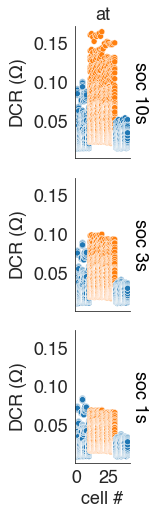

In [11]:
with sns.axes_style("white"):
    
    g = sns.FacetGrid(df_flat, 
                      row="soc", 
                      col="cycle_number", 
                      margin_titles=True, 
                      despine=True,
                      height=2.5)
g.map_dataframe(sns.scatterplot, "cellid", "dcr", hue="is_room_temp_aging", color="#334488")
g.set_titles(col_template="{col_name}", row_template="soc {row_name}")
g.fig.subplots_adjust(wspace=0, hspace=0)    
g.set_axis_labels("cell #", "DCR ($\Omega$)")
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])


In [12]:
df_flat

,cellid,is_room_temp_aging,is_baseline_formation,retention_at_c400,dcr,cycle_number,soc
0,1,0,1,0.492051,0.056651,at,10s
1,1,0,1,0.492051,0.036739,at,3s
2,1,0,1,0.492051,0.028164,at,1s
3,1,0,1,0.492051,0.048262,at,10s
4,1,0,1,0.492051,0.032362,at,3s
...,...,...,...,...,...,...,...
19300,40,0,0,0.817960,0.029944,at,3s
19301,40,0,0,0.817960,0.028235,at,1s
19302,40,0,0,0.817960,0.034345,at,10s
19303,40,0,0,0.817960,0.030081,at,3s
